# Experiment: Compare Filtered Binary - Multi Previous Violation w/ Stim Interaction 

**Goal**: See if a multi model trained with stim interaction pairs does better than a binary model on L/R test trials


Related notebooks:

* `2024_02_15_EXP_fit_prev_violation.ipynb`
* `2024_02_19_EXP_fit_filtered_prev_violation_stim_intrx.ipynb`
* `2024_02_19_EXP_compare_binary_multi_filtered_prev_violation_itrxs.ipynb`

> Written by Jess Breda 

## Imports

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from multiglm.experiments.experiment import load_experiment
from multiglm.experiments.experiment_compare_models import ExperimentCompareModels
from multiglm.features.design_matrix_generator import (
     DesignMatrixGeneratorInteractions, DesignMatrixGeneratorFilteredHistory, DesignMatrixGeneratorPsytrack
)
from multiglm.models.multiclass_logistic_regression import MultiClassLogisticRegression
from multiglm.models.binary_logistic_regression import BinaryLogisticRegression
from multiglm.visualizations.model_visualizer import ModelVisualizerCompare
from multiglm.utils.fitting_utils import create_violation_interaction_pairs
from multiglm.data import ANIMAL_IDS

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

## Model Configs

In [2]:
model_config = {
    "b_psytrack_features": {  # MODEL 0- psytrack binary base
        "model_class": BinaryLogisticRegression,
        "model_type": "binary",
        "design_matrix_generator": DesignMatrixGeneratorPsytrack,
        "filter_implementation": {},  # nothing to filter or drop
    },
    "m_psytrack_features": {  # MODEL 1- pystrack multi base
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "lr_only_eval": True,
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": -1},  # no filter & drop column
    },
    "m_prev_violation": {  # MODEL 2- prev violation bool
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "lr_only_eval": True,
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": 0},  # no filter
    },
    "m_filter_prev_violation": {  # MODEL 3- prev violation filtered
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "lr_only_eval": True,
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau
    },
    "m_filter_prev_violation_stim_itrx": {  # MODEL 4- with filt prev violation history and stim interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "lr_only_eval": True,
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"])
        },
    },
}

params = {
    "animals": ANIMAL_IDS,
    "data_type": "new_trained",
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 20,
    "null_mode": "binary",
    "eval_train": True,
    "tau_columns": ["prev_violation"],
    "model_config": model_config,
}


save_name = "compare_binary_multi_filtered_prev_violation_itrxs_rs20.pkl"
ORDER = [
    "b_psytrack_features",
    "m_psytrack_features",
    "m_prev_violation",
    "m_filter_prev_violation",
    "m_filter_prev_violation_stim_itrx",
]

## Run

In [3]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(save_name)

Loading dataset type : new_trained
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']

 >>>> evaluating animal W051 <<<<

 ***** evaluating model b_psytrack_features w/ sigma 0.07 *****
         Current function value: 31163.545631
         Iterations: 13
         Function evaluations: 63
         Gradient evaluations: 51

 ***** evaluating model b_psytrack_features w/ sigma 0.13 *****
         Current function value: 31548.007507
         Iterations: 13
         Function evaluations: 60
         Gradient evaluations: 48

 ***** evaluating model b_psytrack_features w/ sigma 0.25 *****
         Current function value: 31686.188385
         Iterations: 13
         Function evaluations: 59
         Gradient evaluations: 47

 ***** evaluating model b_psytrack_features w/ sigma 0.5 *****
         Current function value: 31726.833136
         Iterations: 13
         Function ev

## Visualize

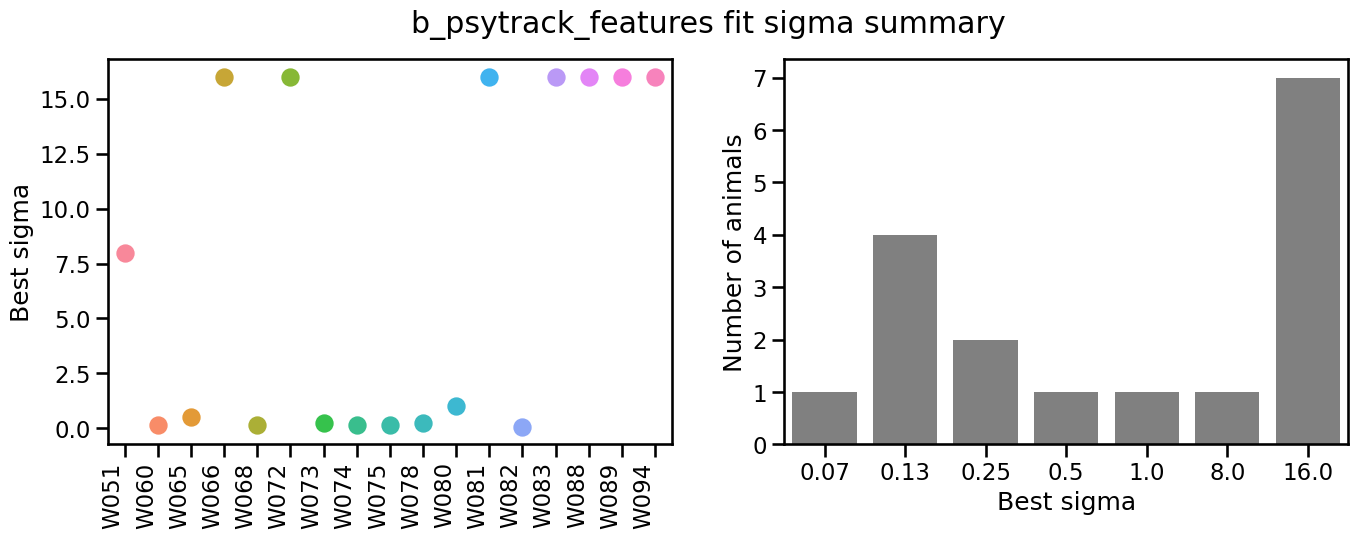

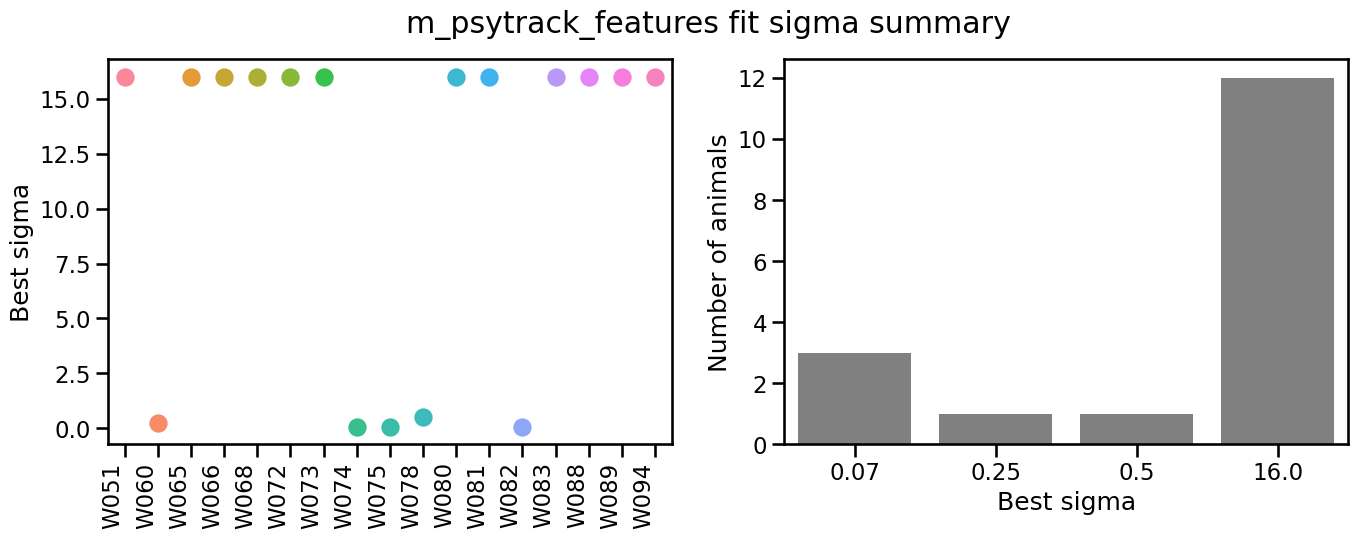

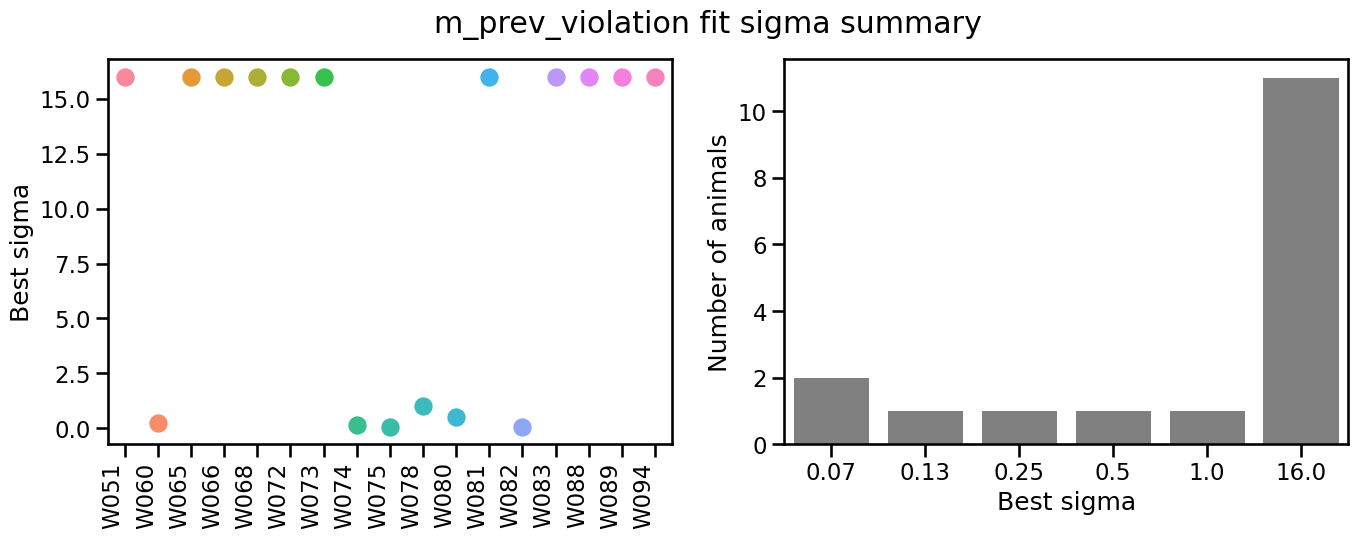

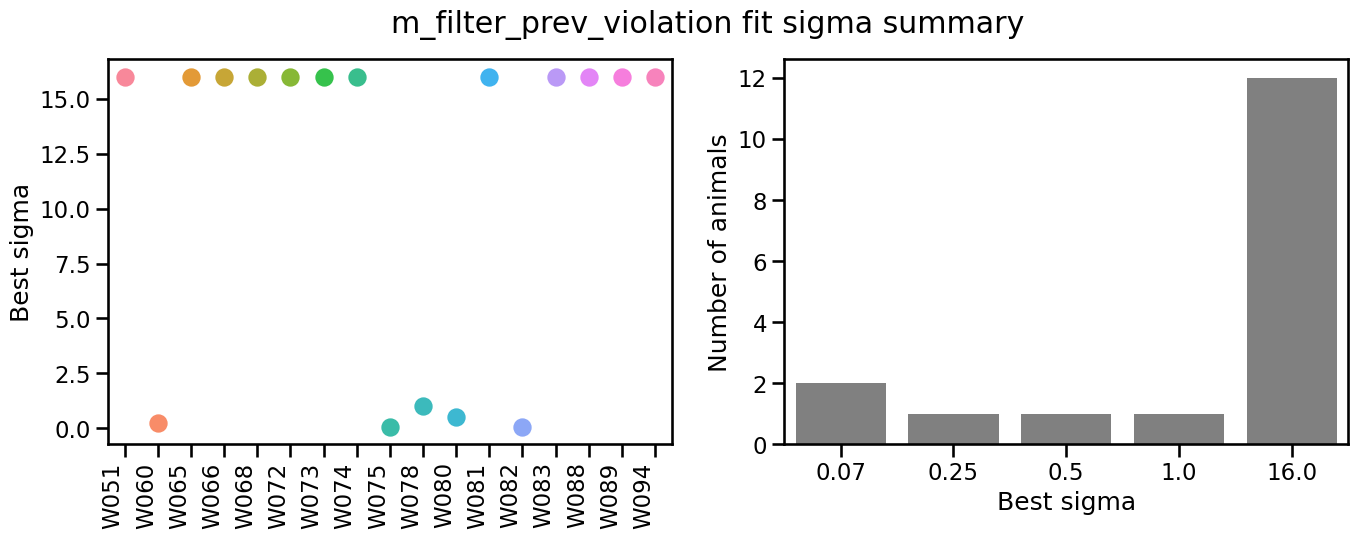

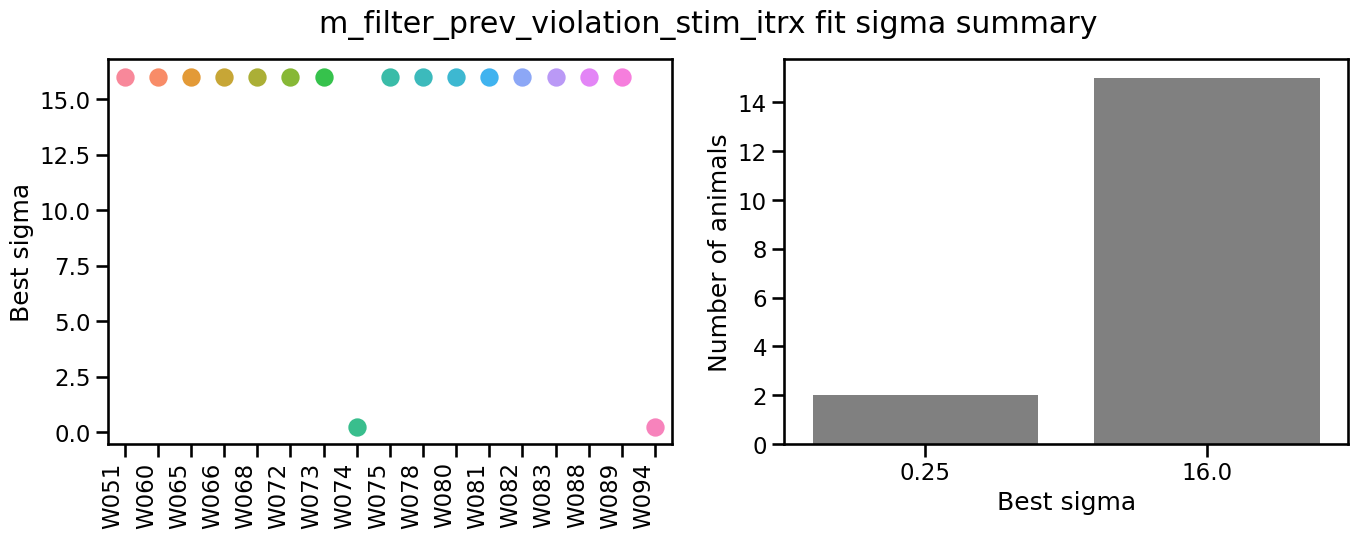

In [4]:
experiment = load_experiment(save_name)
mvc = ModelVisualizerCompare(experiment)

df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

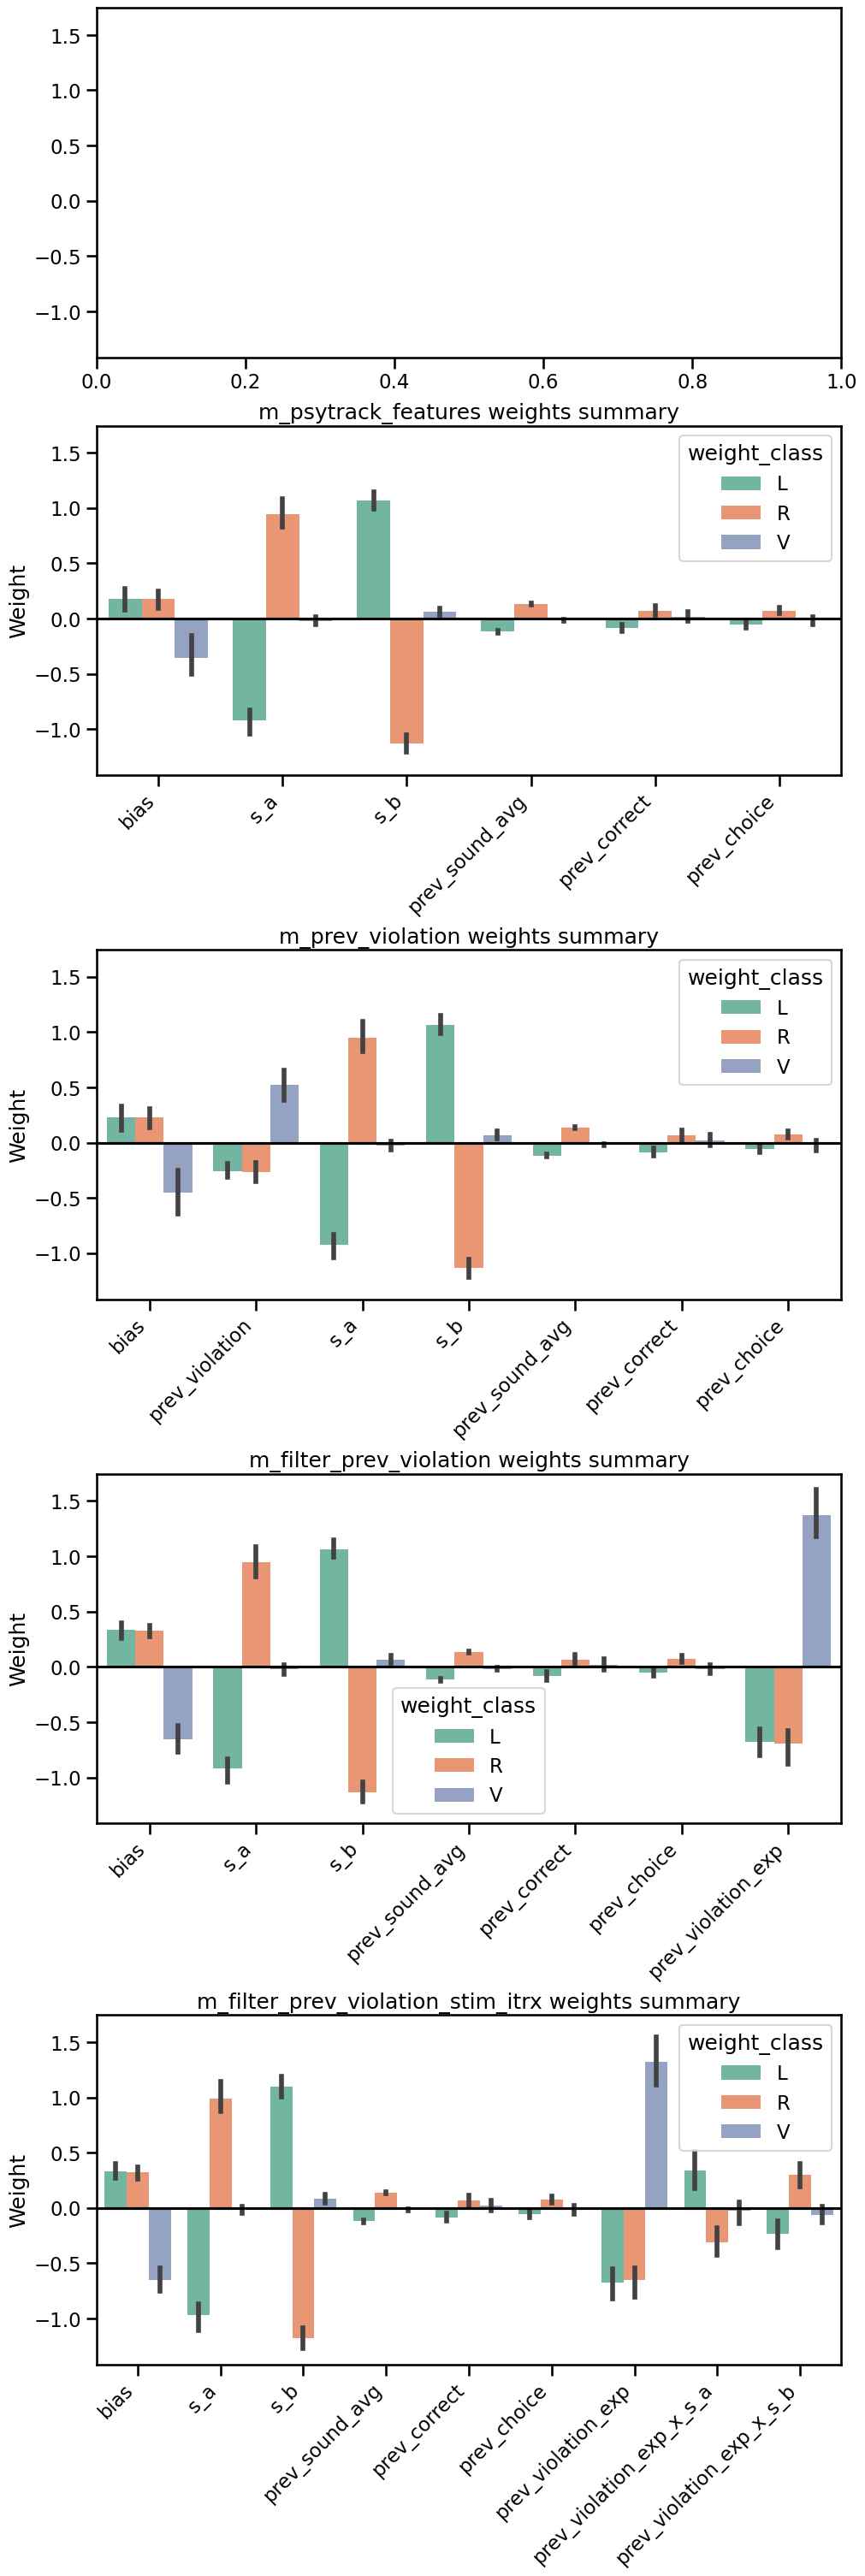

In [5]:
fig, ax = plt.subplots(
    len(ORDER), 1, figsize=(10, len(ORDER) * 6), constrained_layout=True, sharey=True
)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])
best_fit_by_model["model_name"] = pd.Categorical(
    best_fit_by_model["model_name"], categories=ORDER, ordered=True
)

for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    if model_name == ORDER[0]:
        continue
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii],
        palette="Set2",
        title=f"{model_name} weights summary",
    )

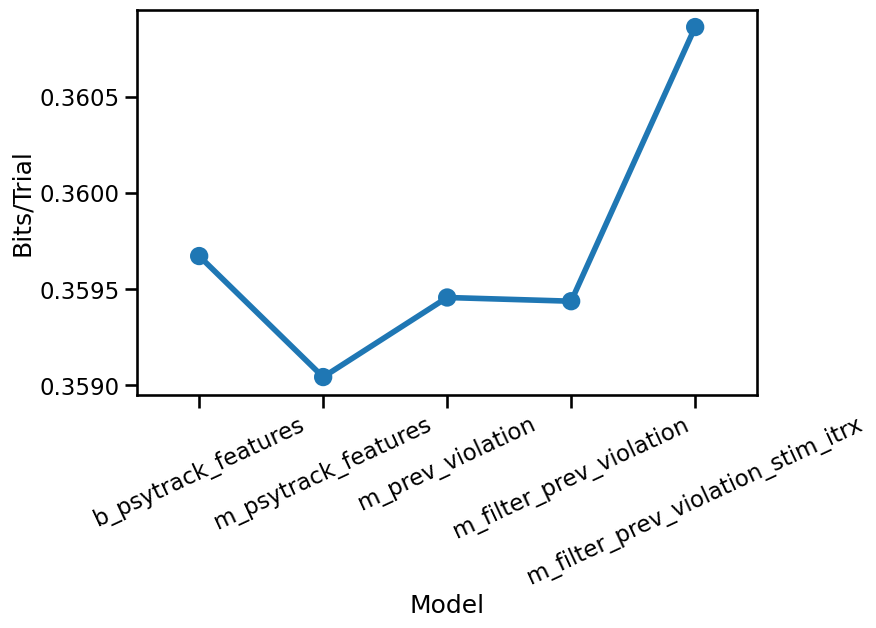

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER,
    errorbar=None,
)

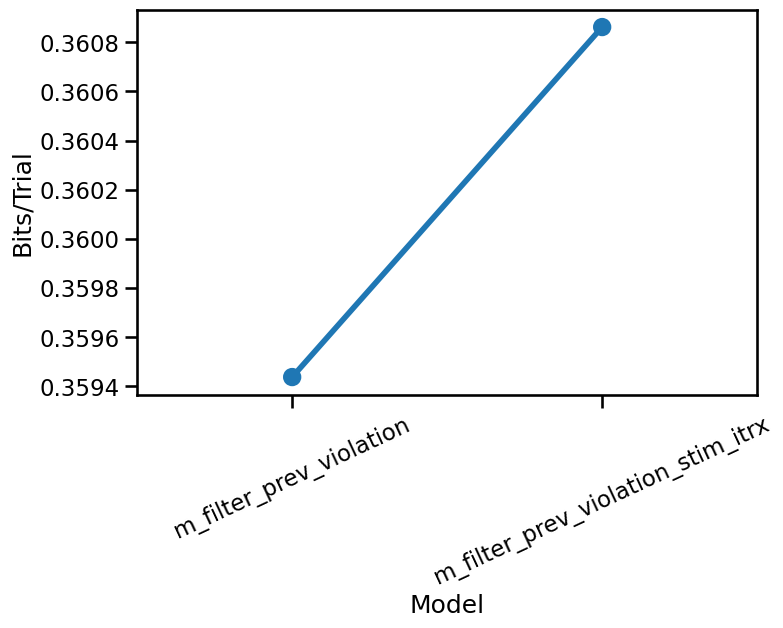

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER[3:],
    errorbar=None,
)

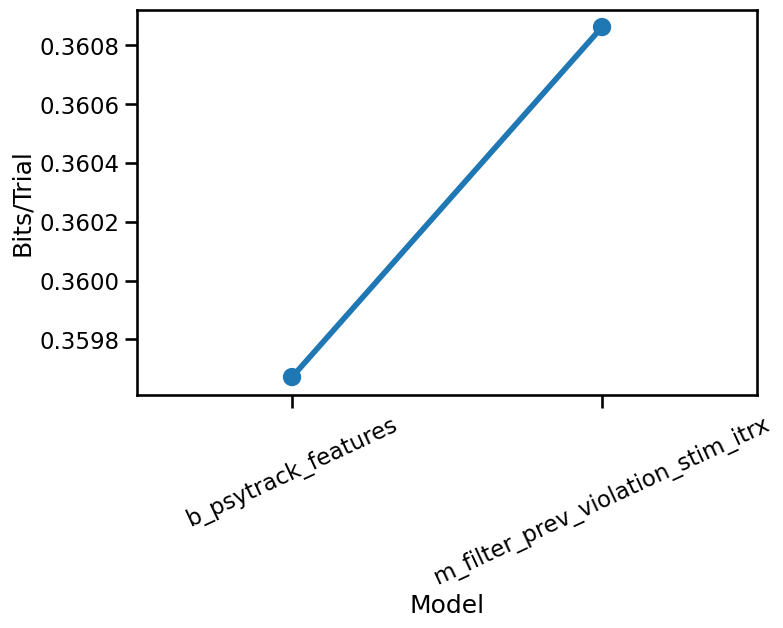

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=[ORDER[0], ORDER[-1]],
    errorbar=None,
)

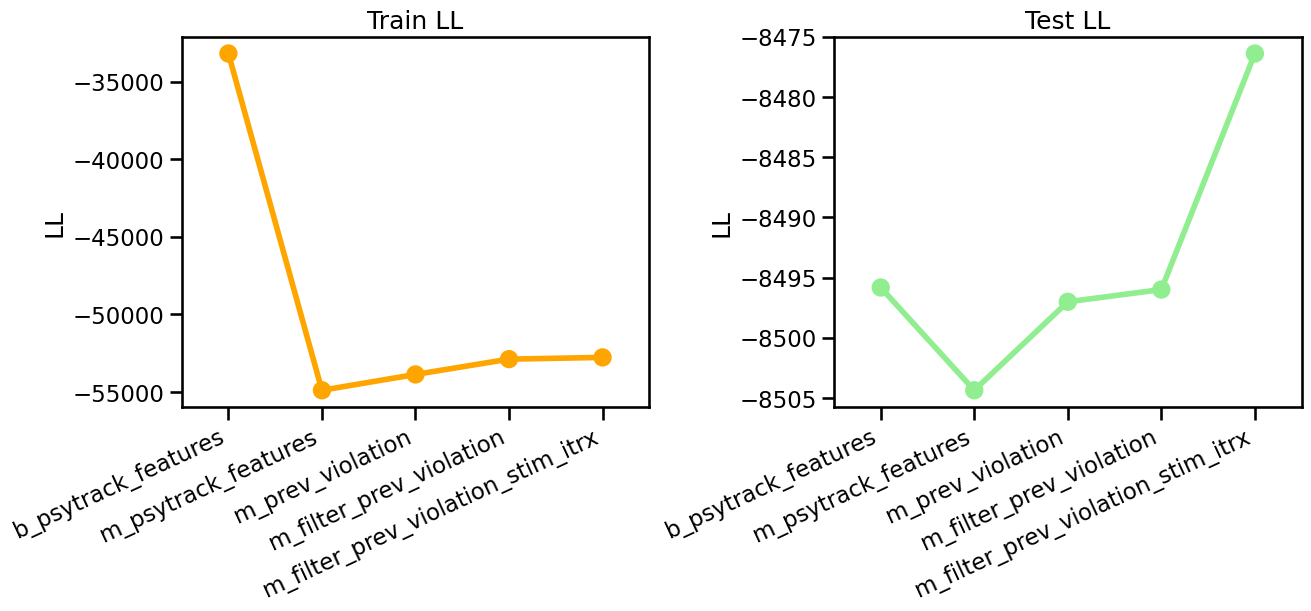

In [9]:
mvc.plot_train_and_test_ll(
    order=ORDER,
    errorbar=None,
)

<Axes: title={'center': 'Model Improvement- mu: 19.44 std: 42.89 \n b_psytrack_features -> m_filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

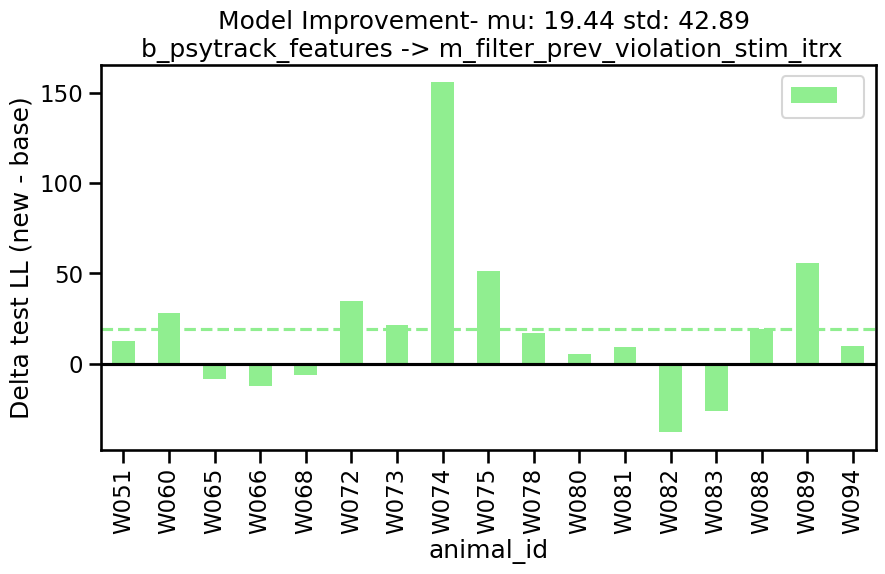

In [10]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[4],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 20.62 std: 24.82 \n m_prev_violation -> m_filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

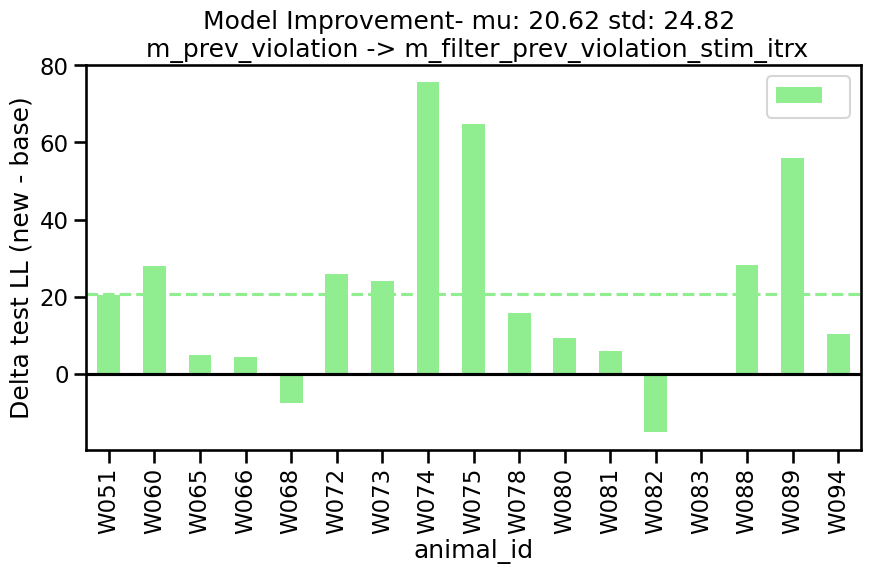

In [11]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[2],
    new_model_name=ORDER[4],
    type="test",
)

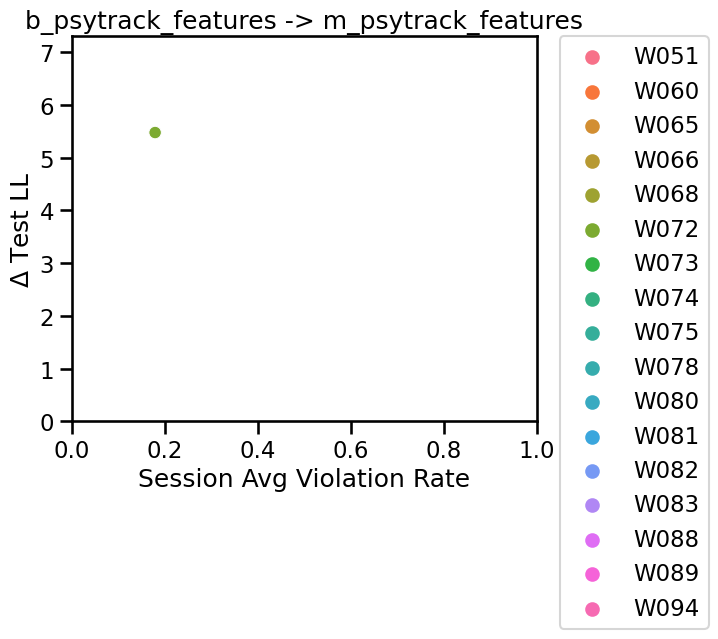

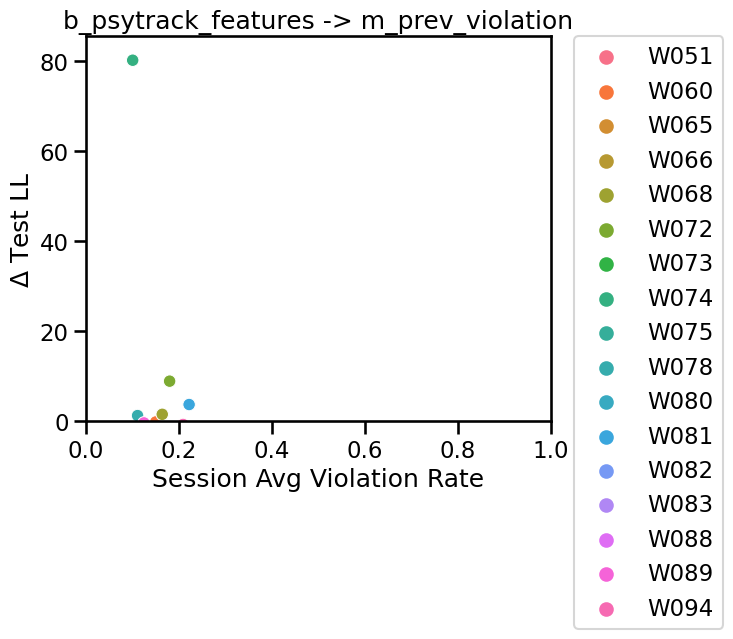

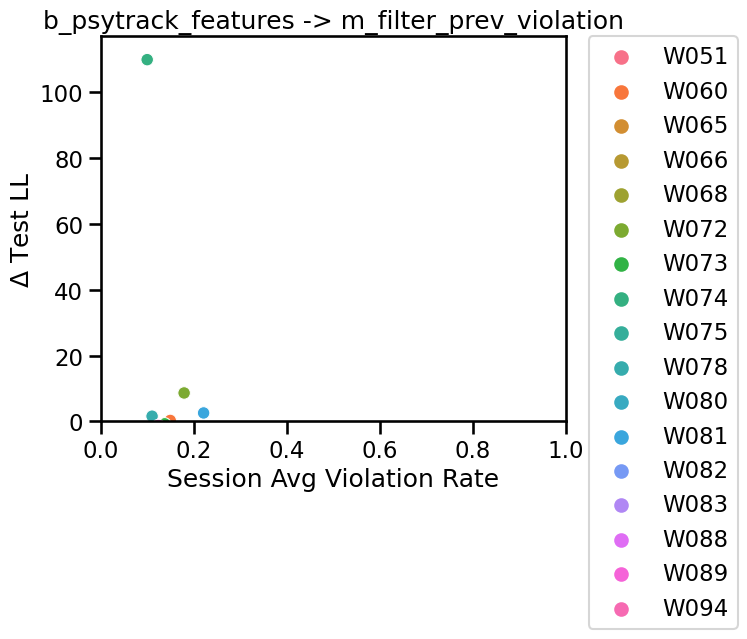

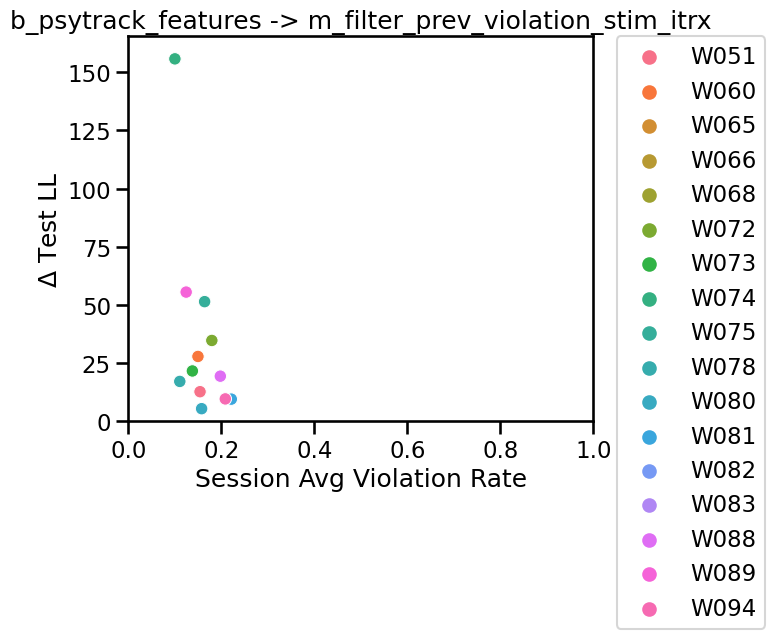

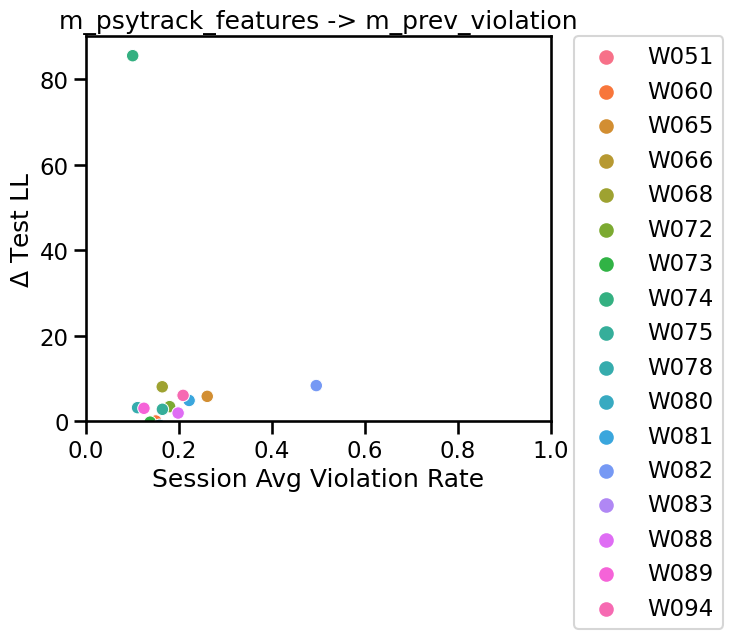

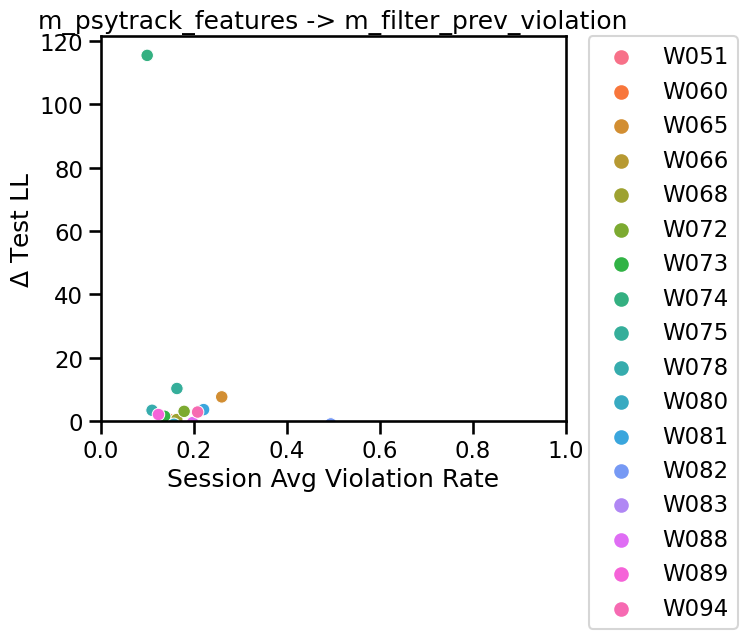

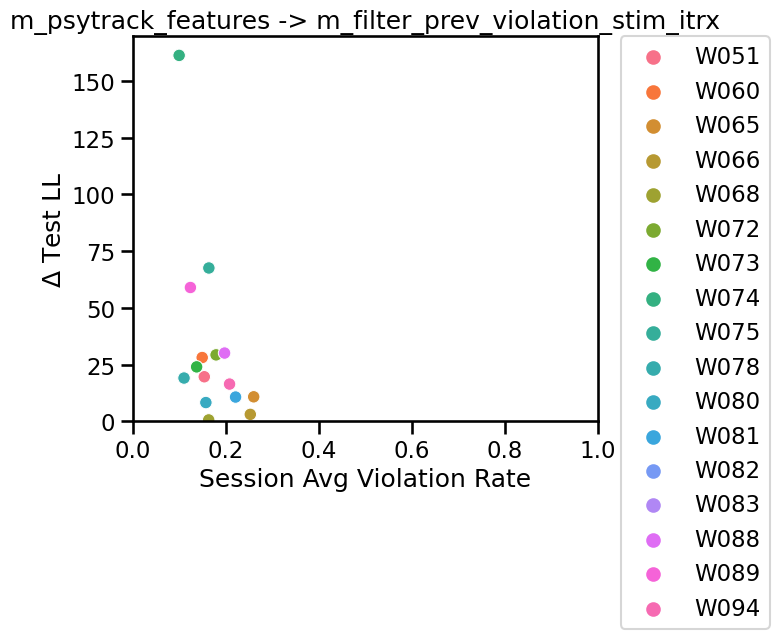

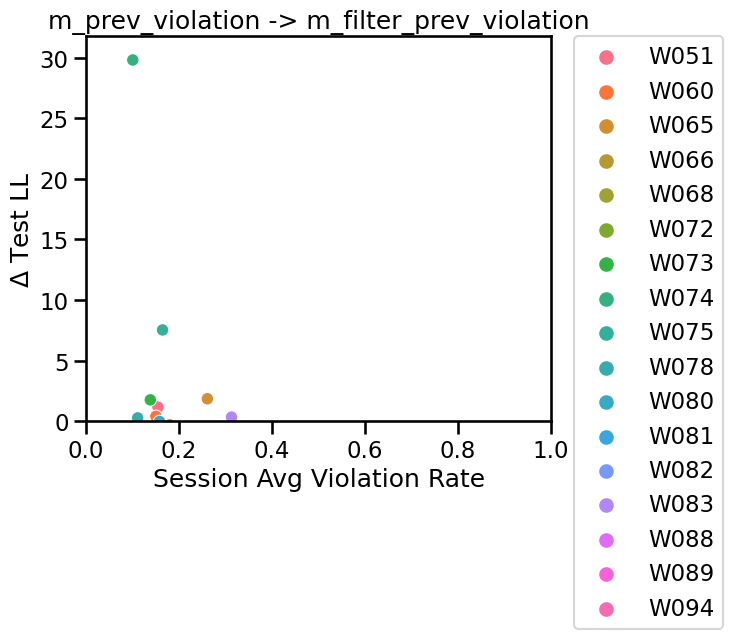

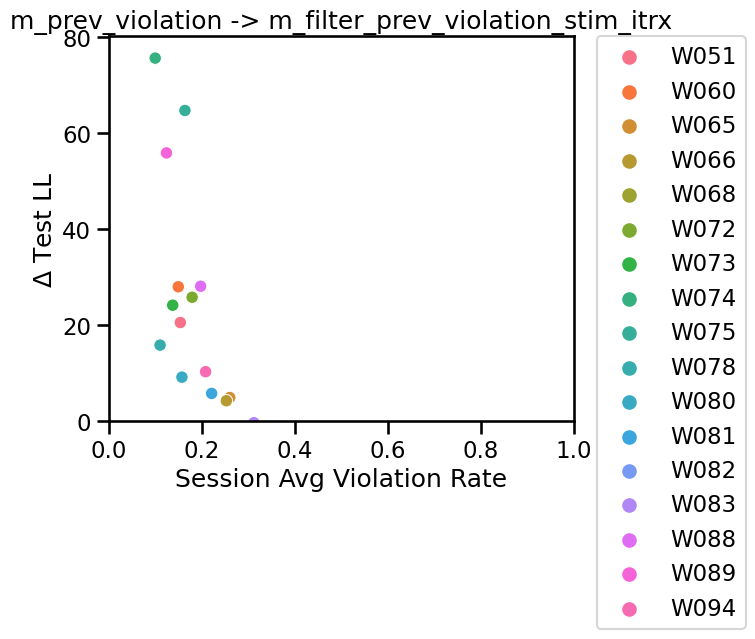

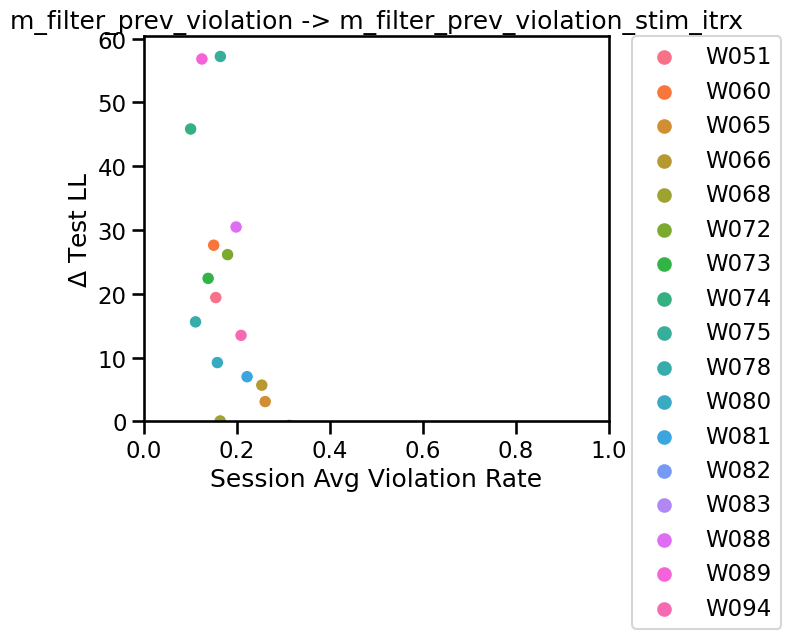

In [12]:
for i in range(len(ORDER)):
    for j in range(i + 1, len(ORDER)):
        mvc.plot_delta_ll_by_violation_rate(ORDER[i], ORDER[j])

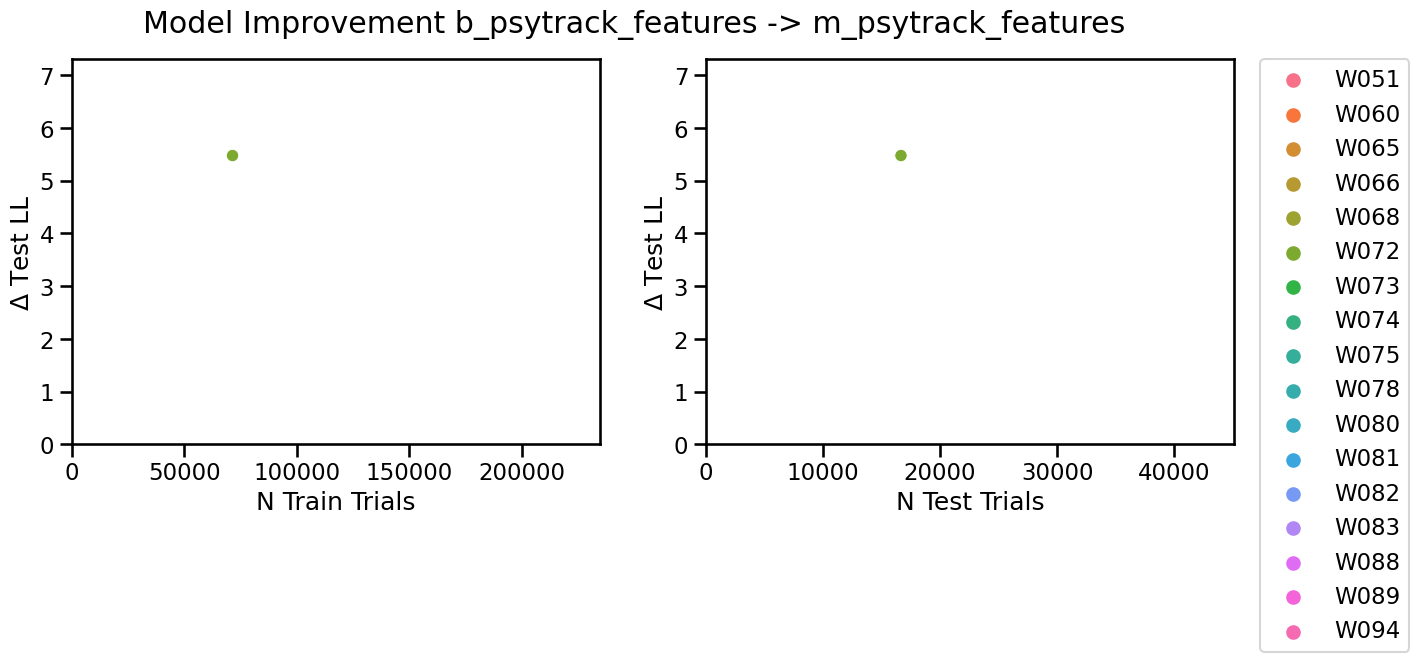

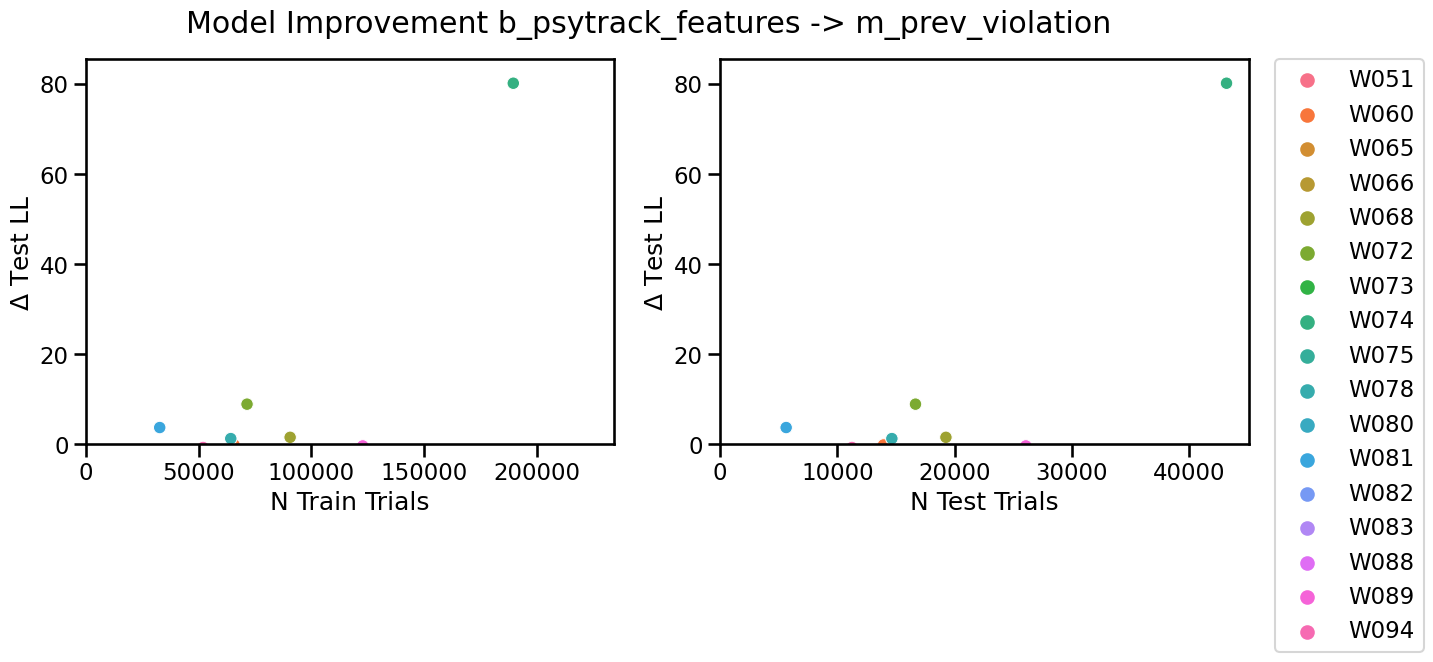

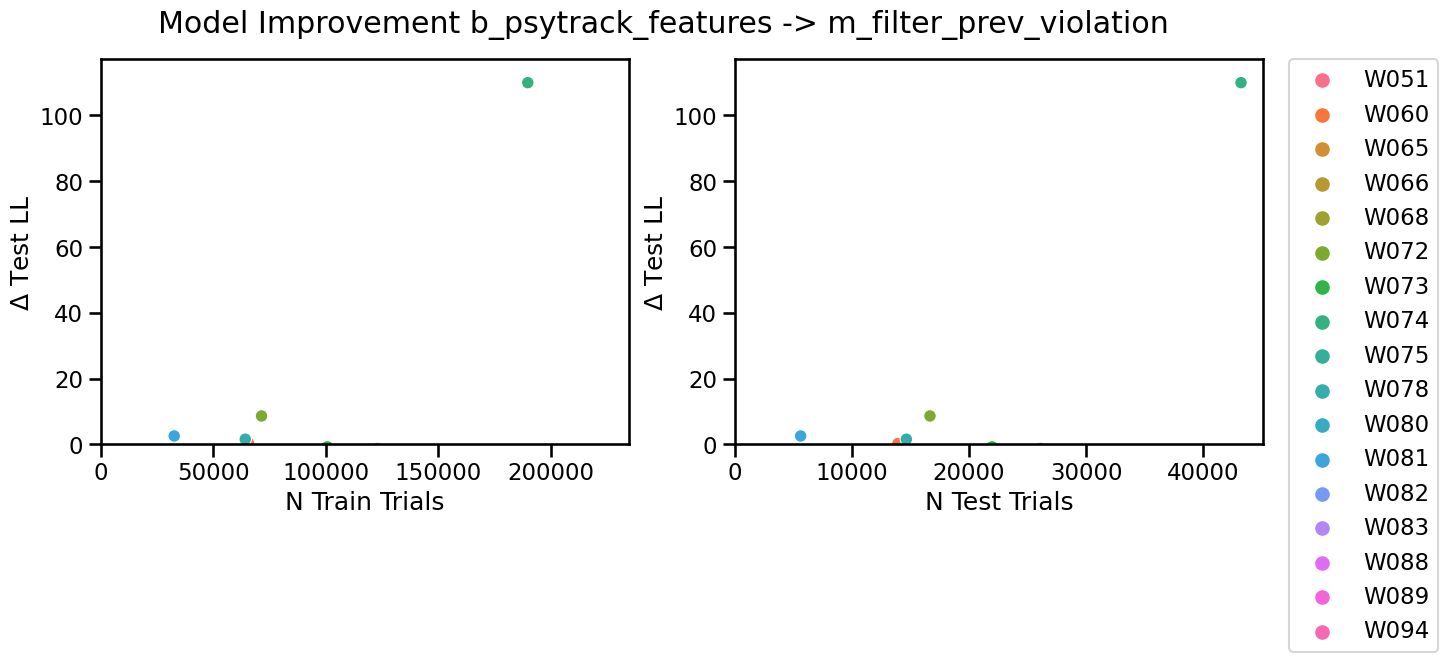

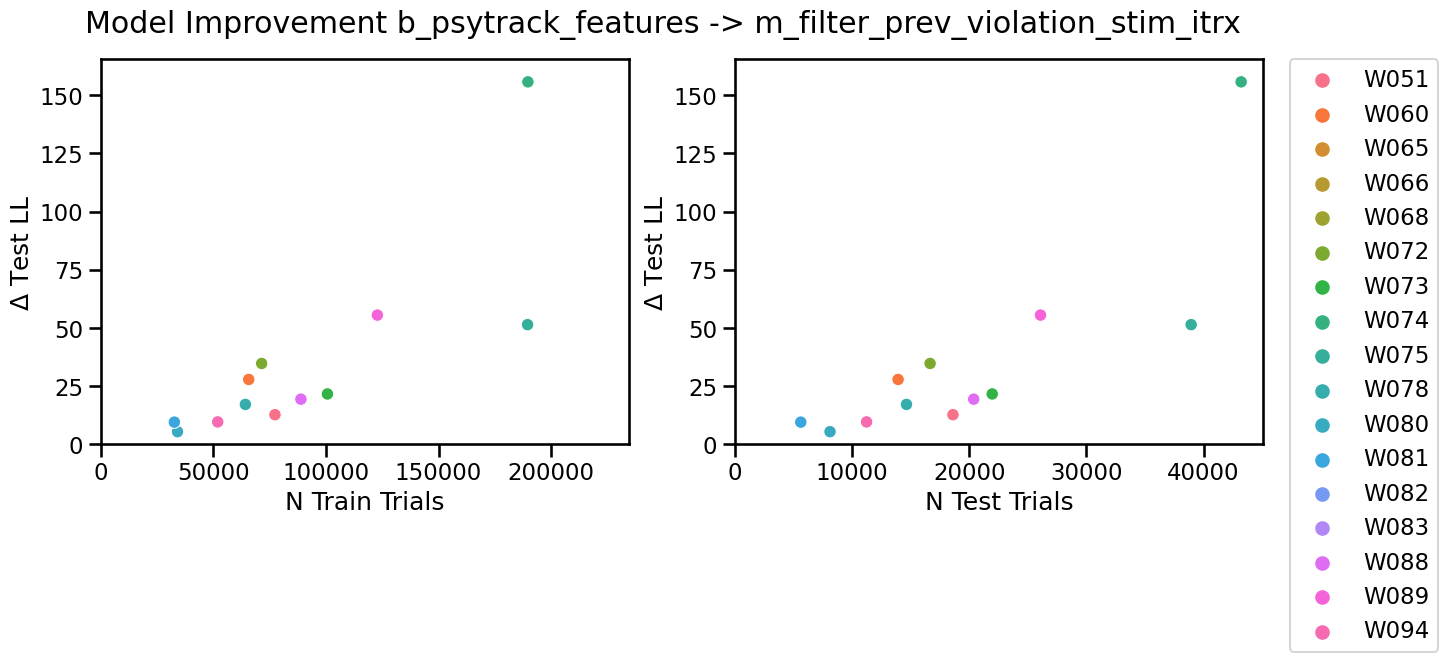

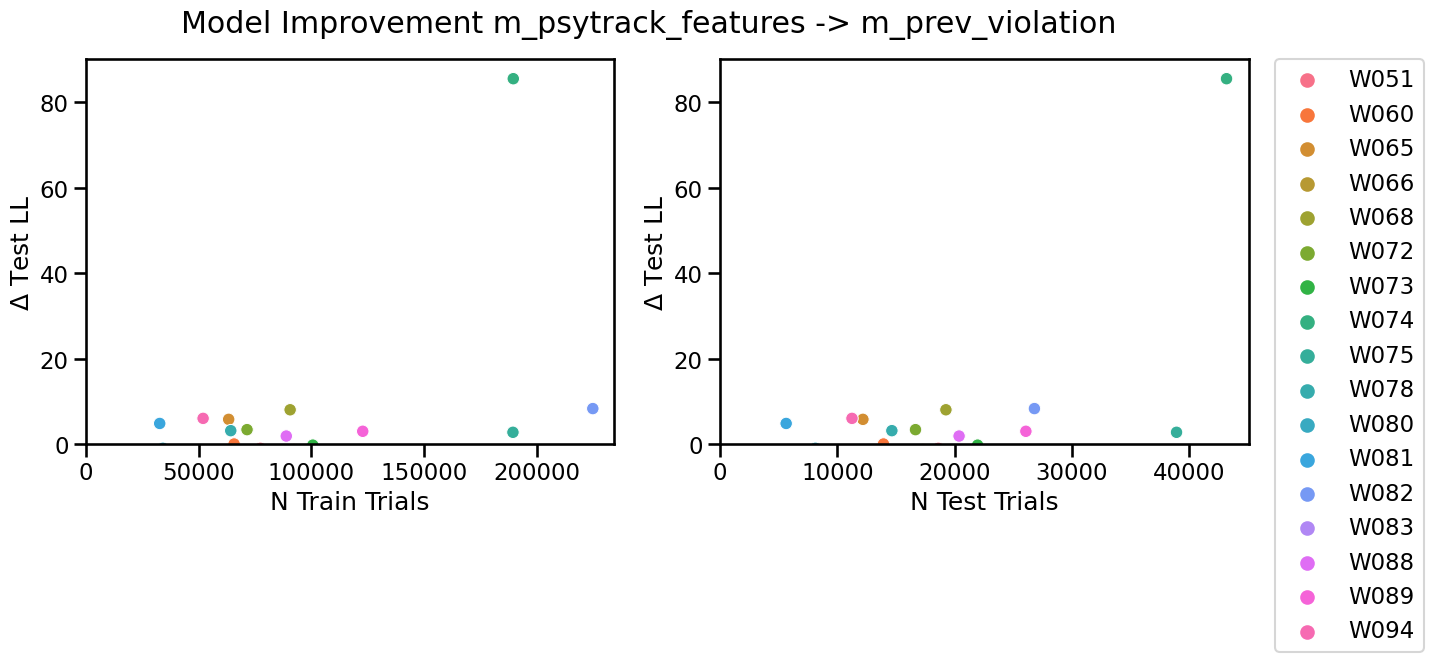

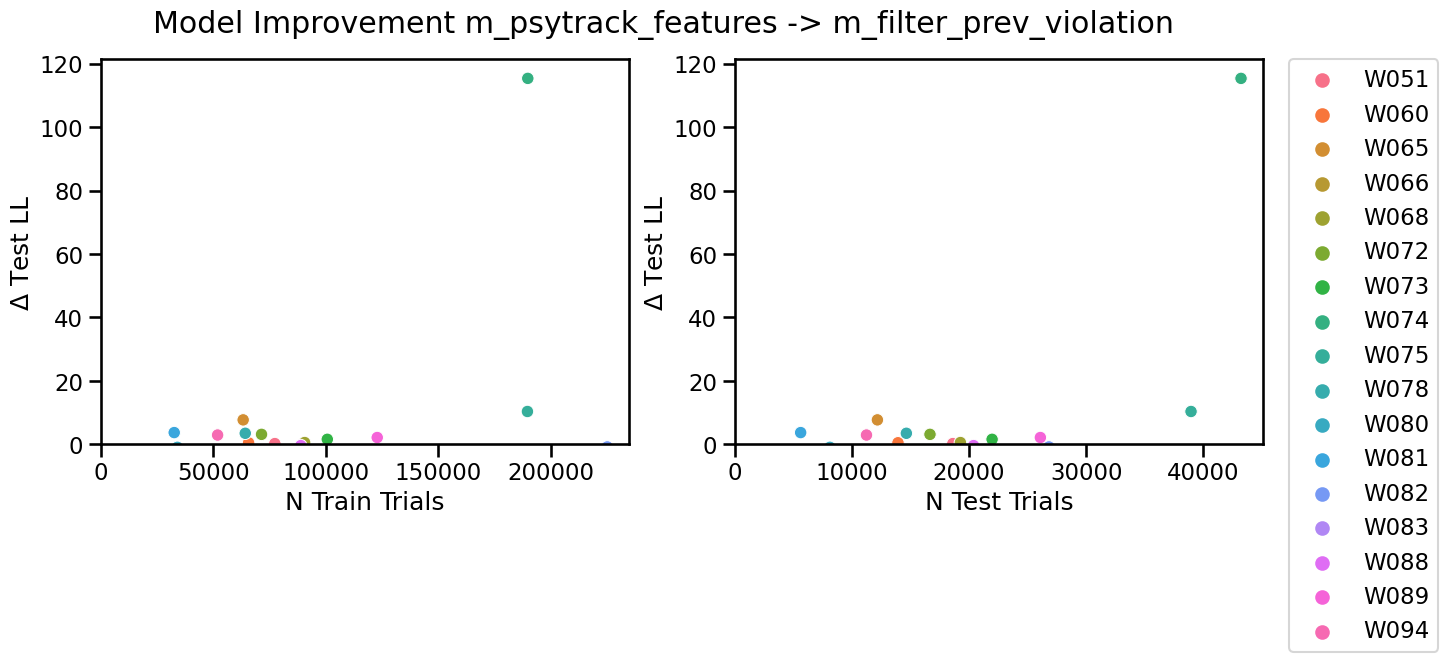

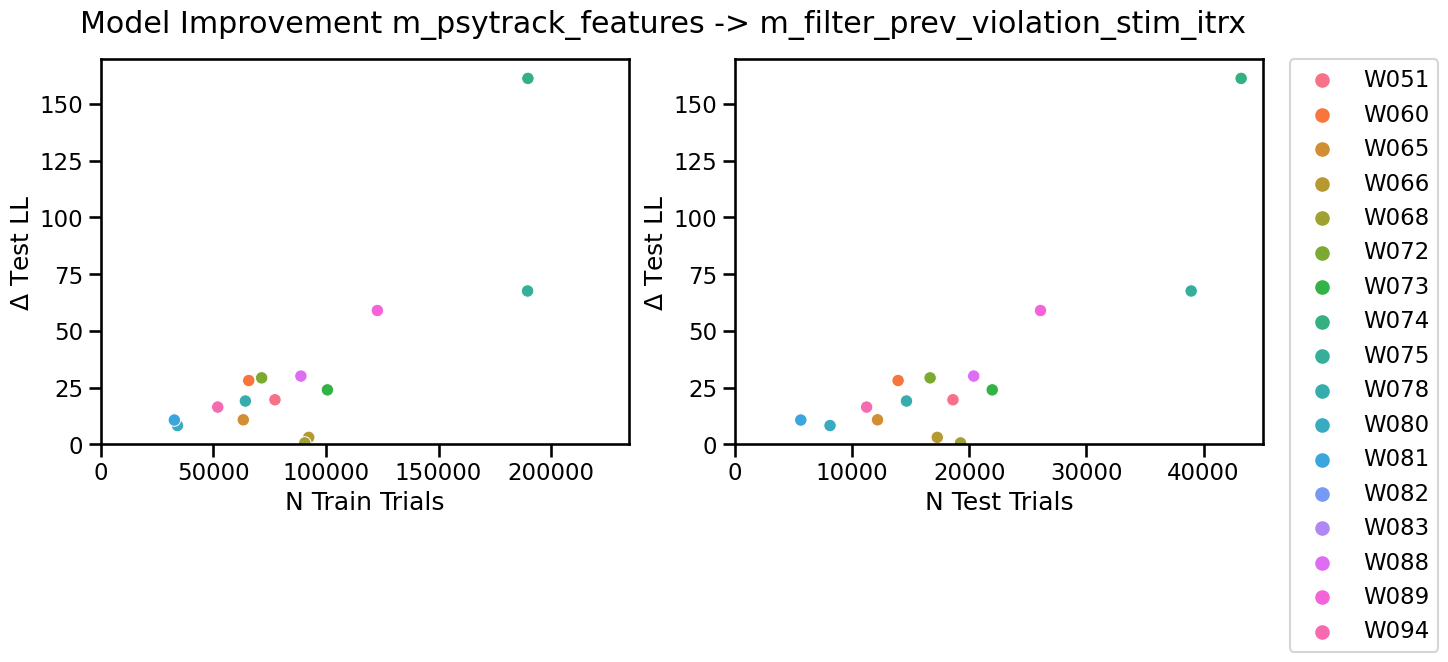

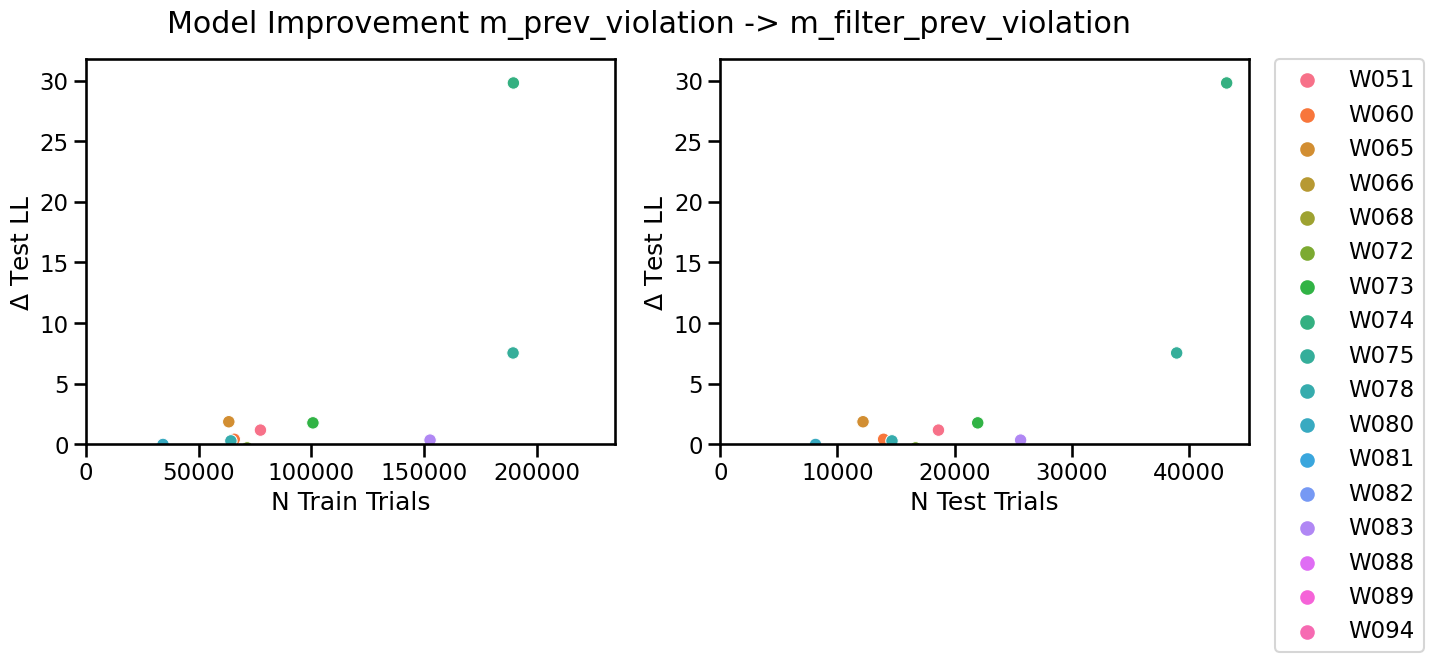

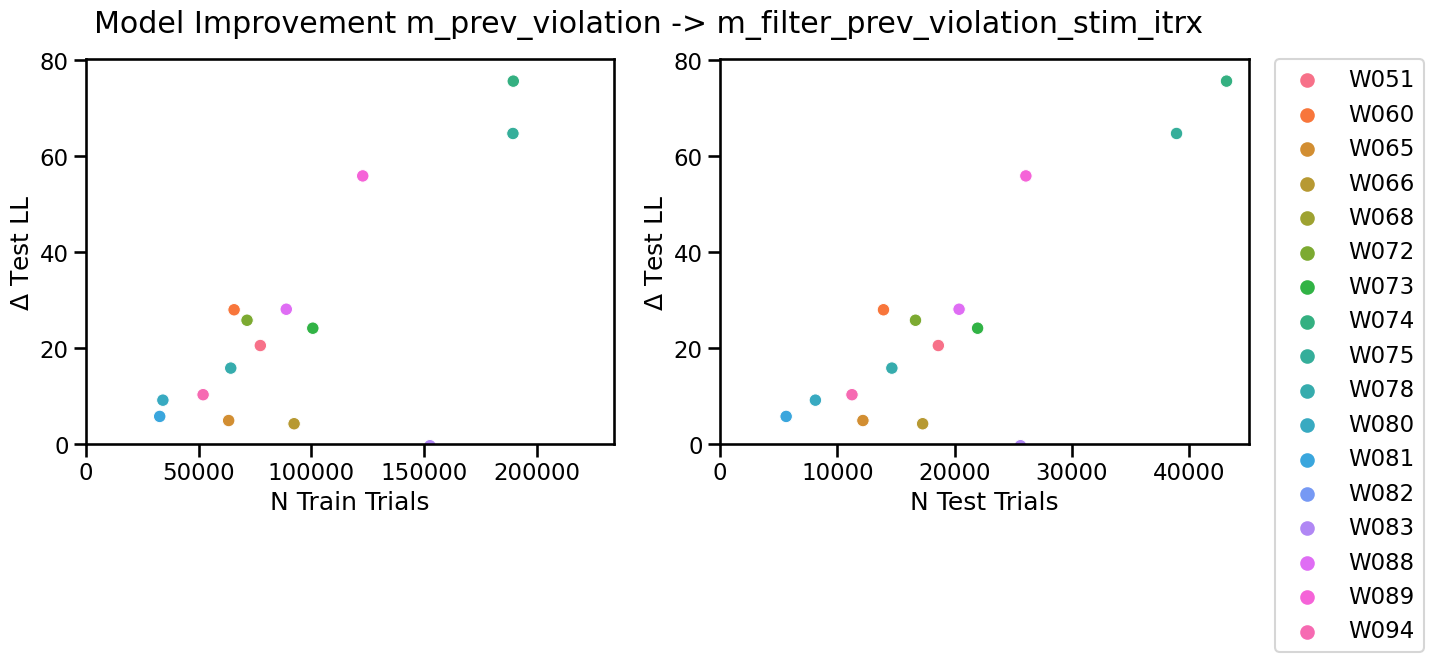

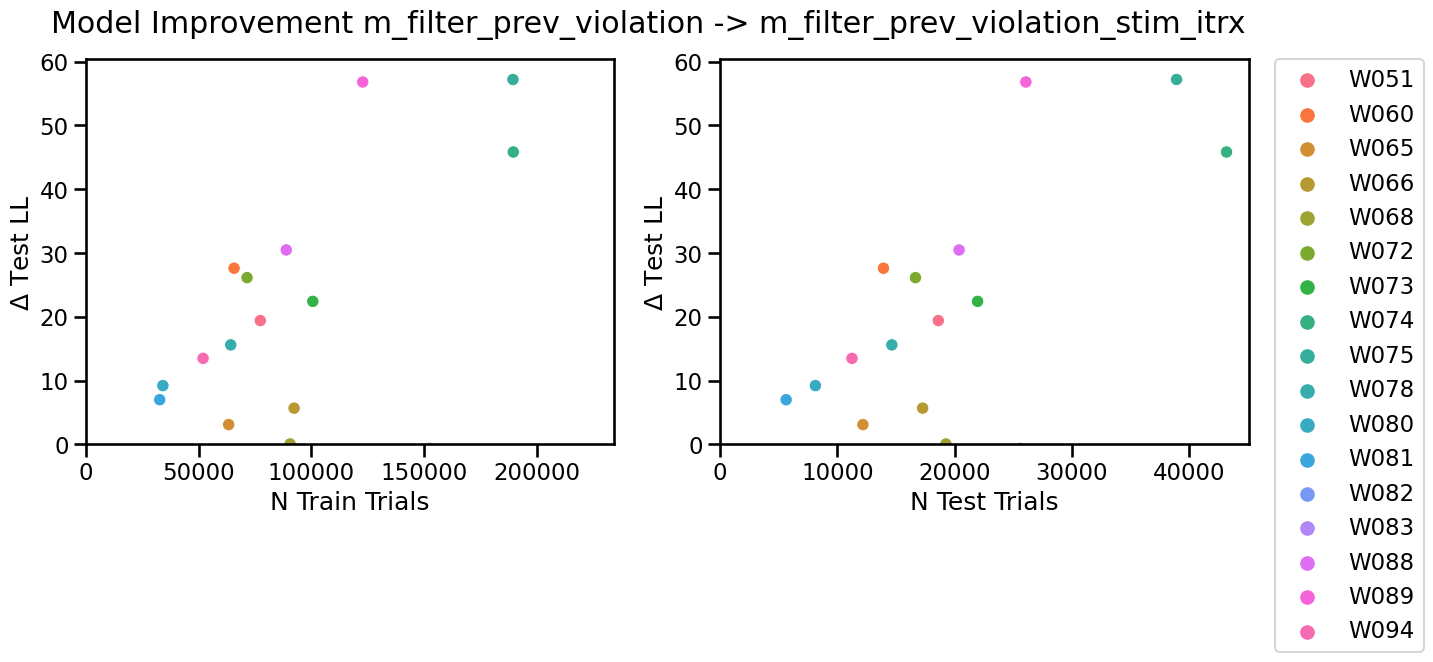

In [13]:
for i in range(len(ORDER)):
    for j in range(i + 1, len(ORDER)):
        mvc.plot_delta_ll_by_train_test_size(ORDER[i], ORDER[j])

In [14]:
# TODO- bits per trial vs violation rate?

In [15]:
# TODO- bits per trial vs violation rate?